In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from score_models import VE, VP
from dataclasses import dataclass
from torch import distributions

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from torch import Tensor
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)
#torch.manual_seed(1)
#np.random.seed(2)

## Define Data

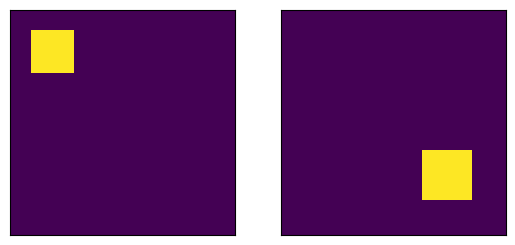

torch.Size([2, 4096])


In [10]:
N    = 2
size = 64
dim  = size**2

# define data
data = torch.zeros((N,size,size))
data[0,6:18,6:18] = 1.0
data[1,40:54,40:54] = 1.0

# plot samples
for j in range(N):
    plt.subplot(1,2,j+1)
    plt.imshow(data[j,...])
    plt.xticks([])
    plt.yticks([])
plt.show()

# reshape data
data = data.reshape((N, dim))
print(data.shape)

## Define models

In [11]:
from score_models import VE, VP
model = VE()
model.eps = 0.

In [21]:
class GMM_score(nn.Module):
    def __init__(self, train_data, marginal_prob_mean, marginal_prob_std, constant=0.0):
        super().__init__()
        self.train_data = train_data
        self.marginal_prob_mean = marginal_prob_mean 
        self.marginal_prob_std  = marginal_prob_std
        self.constant = constant

    def pdf_weights(self, x, t):
        # compute mean and sigma
        sigma = self.marginal_prob_std(t)
        meanf = self.marginal_prob_mean(t)
        # evaluate Gaussian densities
        logpdf_x_yi = torch.zeros((x.shape[0],self.train_data.shape[0]))
        for i in range(self.train_data.shape[0]):
            logpdf_x_yi[:,i] = self.log_normal_pdf(x, meanf[:,None] * self.train_data[i,:], sigma)
        # compute weighted average
        weights = torch.softmax(logpdf_x_yi, axis=1)
        return weights
        
    def forward(self, x, t):
        # compute weights
        weights = self.pdf_weights(x, t)     
        # compute sigma
        sigma = self.marginal_prob_std(t)
        # compute weighted average
        evals = torch.mm(weights, self.train_data) 
        evals[torch.isnan(evals)] = 0.0
        sigma2 = self.marginal_prob_std(t)**2
        return (evals - x)/(sigma2[:, None] + self.constant)

    def log_normal_pdf(self, x, y, sigma):
        # ignoring normalization constant
        assert(x.shape[0] == len(sigma))
        return -0.5*torch.sum((x - y)**2,axis=1)/sigma**2

    def normal_pdf(self, x, y, sigma):
        return torch.exp(self.log_normal_pdf(x, y, sigma))

# define GMM
gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, model.marginal_prob_std, constant=0.0)

# test network
dim = data.shape[1]
rand_x = torch.randn(1000, dim).to(device)
rand_t = torch.rand(1,) * torch.ones((1000,1))
print(gmm_train(rand_x, rand_t[:,0]).shape)

torch.Size([1000, 4096])


/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_8541/618395203.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, model.marginal_prob_std, constant=0.0)


## Compute model weights

In [19]:
from scipy import integrate

def ode_sampler(score_net, model, latents):
    
    # define initial samples
    init_T = model.T * torch.ones(batch_size, device=latents.device)
    init_x = latents * model.marginal_prob_std(init_T)[:, None]
    
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(latents.shape)
        with torch.no_grad():    
            score = score_net(sample, time_steps)
        return score
    
    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        batch_time = torch.ones(batch_size, device=latents.device) * t
        g = model.diffusion_coeff(batch_time)
        f = model.drift(x.reshape(latents.shape), batch_time)
        rhs = f - 0.5*(g**2)[:,None] * score_eval_wrapper(x, batch_time)
        return rhs.detach().numpy().reshape((-1,)).astype(np.float64)
    
    # Run the black-box ODE solver
    err_tol = 1e-5
    res = integrate.solve_ivp(ode_func, (model.T, model.eps), init_x.reshape(-1).cpu().numpy(), rtol=err_tol, atol=err_tol, method='RK45', dense_output=True)  
    return (res.t, res.y)

### Plot ODE weights

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_8541/496478100.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32),


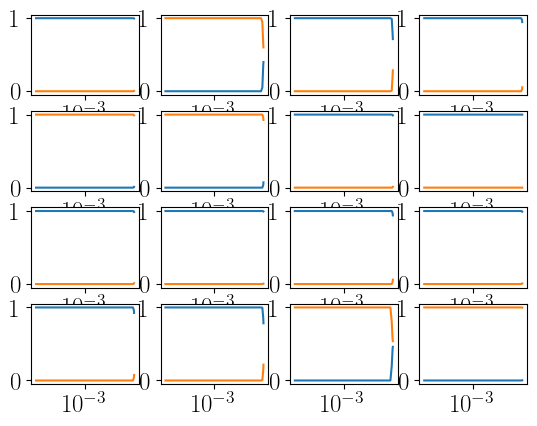

In [42]:
# define latent samples
batch_size = 16
latents = torch.randn(batch_size, dim).to(device)

# define GMM
gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), 
                      model.marginal_prob_mean, model.marginal_prob_std, constant=0.0)

# evaluate ODE and SDE paths
GMM_t, GMM_x = ode_sampler(gmm_train, model, latents)

# define array to store weights
GMMweights = torch.zeros((len(GMM_t),batch_size,gmm_train.train_data.shape[0]))

# evaluate the ODE weights
for (j,tj) in enumerate(GMM_t):
    sample = torch.tensor(GMM_x[:,j], device=latents.device, dtype=torch.float32).reshape(latents.shape)
    batch_time = torch.ones(batch_size, device=latents.device) * tj
    GMMweights[j,:,:] = gmm_train.pdf_weights(sample, batch_time)

plt.figure()
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.semilogx(GMM_t, GMMweights[:,i,:])

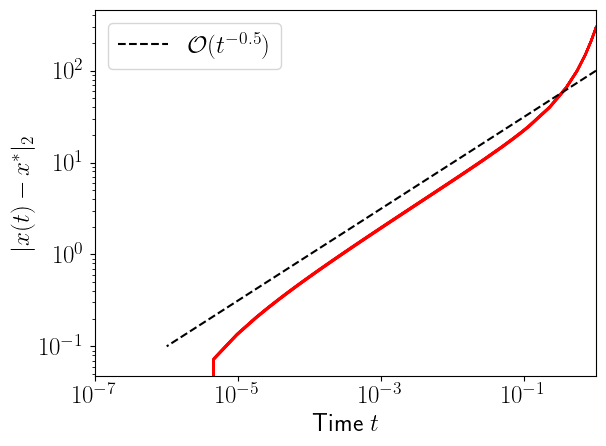

In [47]:
res_loc = torch.tensor(GMM_x, device=latents.device, dtype=torch.float32).reshape(batch_size,dim, -1)

plt.figure()
for i in range(batch_size):
    # compute distance to final point
    dist = torch.sqrt(torch.sum((res_loc[i,:,:] - res_loc[i,:,-1][:,np.newaxis])**2, axis=0))
    plt.loglog(GMM_t, dist, '-r', alpha=0.8)
plt.loglog(GMM_t, 100*(GMM_t)**0.5, '--k', label = '$\mathcal{O}(t^{-0.5})$')
plt.xlabel('Time $t$')
plt.ylabel('$|x(t) - x^*|_2$')
plt.legend()
plt.xlim(1e-7,1)
plt.tight_layout()
plt.show()

## Solve regularized problem

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_8541/1597333737.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32),


torch.Size([16, 4096])


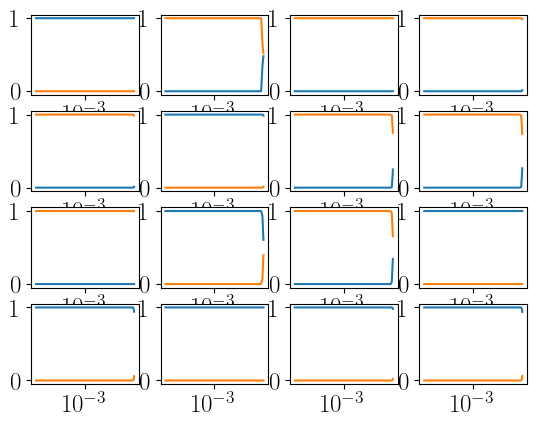

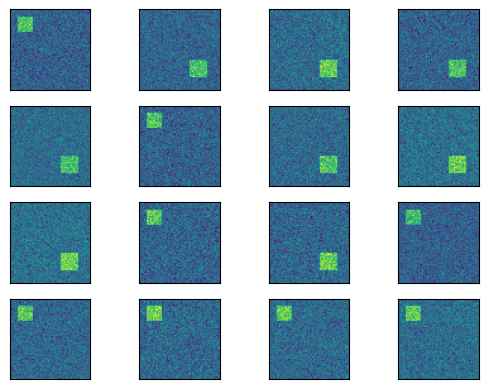

In [51]:
# define latent samples
batch_size = 16
reg_constant = 0.05
latents = torch.randn(batch_size, dim).to(device)

# redefine GMM
gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), 
                      model.marginal_prob_mean, model.marginal_prob_std, constant=reg_constant)

# evaluate ODE and SDE paths
GMM_t, GMM_x = ode_sampler(gmm_train, model, latents)

# define array to store weights
GMMweights = torch.zeros((len(GMM_t),batch_size,gmm_train.train_data.shape[0]))

# evaluate the ODE weights
for (j,tj) in enumerate(GMM_t):
    sample = torch.tensor(GMM_x[:,j], device=latents.device, dtype=torch.float32).reshape(latents.shape)
    batch_time = torch.ones(batch_size, device=latents.device) * tj
    GMMweights[j,:,:] = gmm_train.pdf_weights(sample, batch_time)

plt.figure()
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.semilogx(GMM_t, GMMweights[:,i,:])

final_samples = torch.tensor(GMM_x[:,-1], device=latents.device, dtype=torch.float32).reshape(latents.shape)
print(final_samples.shape)
plt.figure()
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.imshow(final_samples[i,...].reshape(size,size))
    plt.xticks([])
    plt.yticks([])
plt.savefig('rectangle-samples-Tikonov-'+str(reg_constant)+'.pdf')